Overview

As you continue working on your capstone project, remember that you’ll need to create your own system to stay on schedule for completion. Regularly check in with your mentor and agree on goals to help you manage the workload.

This is your first milestone report. Before submitting this report, please ensure that you have:

- completed a project proposal 
- compiled a data set, wrangled and cleaned it
- explored it with descriptive statistics and visualization techniques
- explored it with inferential statistics techniques.

These steps are the same ones that you followed in your first project. Feel free to go back and revise the learning resources for the first project, if you’d like to enhance the content.

In this unit, you’ll write a draft of your milestone report, which is an early draft of the final capstone project 2 report.

In [1]:
import os
import pandas as pd
import  datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns

from sklearn.model_selection import train_test_split

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
##https://stackoverflow.com/questions/59112197/importerror-cannot-import-name-evaluate-from-surprise-import-evaluate
from scipy.sparse.linalg import svds

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import warnings; warnings.simplefilter('ignore')



## Movie dataset

## Data preprocessing

1. Load original CSV files.
2. Split title and year into separate columns. Convert year to datetime.
3. Categorize genres properly: split strings into boolean columns per genre.
4. Modify the rating timestamp: from universal seconds to datetime year.
5. Check for NaN values.

In [2]:
## https://grouplens.org/datasets/movielens/20m/
data_path = '/Users/yangx/Downloads/ml-20m/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings2.csv'
tags_filename='tags.csv'
df_tags = pd.read_csv(os.path.join(data_path, tags_filename))
df_movies = pd.read_csv(os.path.join(data_path, movies_filename),usecols=['movieId', 'title','genres'], dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(os.path.join(data_path, ratings_filename), usecols=['userId', 'movieId', 'rating','timestamp'], 
                         dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'}
#                          ,parse_dates=['timestamp'],date_parser = pd.datetools.to_datetime
                        )

In [3]:
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [4]:
# add movie title to the df_ratings
df_ratings=df_ratings.merge(df_movies[['movieId','title']], how='left', on='movieId')

In [5]:
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
df_tags.head(3)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079


In [7]:
df_ratings.shape

(20000263, 5)

In [8]:
df_ratings.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [9]:
df_ratings.userId.nunique()

138493

In [10]:
df_ratings.movieId.nunique()

26744

1. rating range is from 0.5 to 5 with average rating as 3.49 and median as 3.5. It seems that the rating is closer to normal since mean and meidan are very close to each other

In [11]:
print('time range of the dataset',df_ratings.timestamp.min(), df_ratings.timestamp.max())

time range of the dataset 1995-01-09 11:46:44 2015-03-31 06:40:02


In [12]:
# add year column to the ratings
df_ratings['rating_year']=pd.to_datetime(df_ratings.timestamp)
df_ratings['rating_month']=df_ratings.rating_year.dt.month
df_ratings['rating_year']=df_ratings.rating_year.dt.year

## add new features: year and generes to movie data set

In [13]:
# df_movies2=df_movies.copy()
# df_movies2.genres = df_movies2.genres.str.split('|')
# df_movies2 = explode(df_movies2, ['genres'])
# df_movies2.head()
#Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
df_movies['year']=df_movies.title.str.extract("\((\d{4})\)", expand = True)
df_movies['year'] = pd.to_datetime(df_movies.year, format='%Y')
# extract year digits
df_movies.year=df_movies.year.dt.year 
# As there are some NaN years, resulting type will be float (decimals)
#edit title
df_movies['title2']=df_movies.title.str[:-7]
df_movies.head()

,movieId,title,genres,year,title2
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II


In [14]:
genres_unique = pd.DataFrame(df_movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
df_movies = df_movies.join(df_movies.genres.str.get_dummies().astype(bool))
df_movies.drop('genres', inplace=True, axis=1)
df_movies.head()

,movieId,title,year,title2,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,Toy Story,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995.0,Jumanji,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),1995.0,Grumpier Old Men,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),1995.0,Waiting to Exhale,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),1995.0,Father of the Bride Part II,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [15]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             27278 non-null  int32  
 1   title               27278 non-null  object 
 2   year                27256 non-null  float64
 3   title2              27278 non-null  object 
 4   (no genres listed)  27278 non-null  bool   
 5   Action              27278 non-null  bool   
 6   Adventure           27278 non-null  bool   
 7   Animation           27278 non-null  bool   
 8   Children            27278 non-null  bool   
 9   Comedy              27278 non-null  bool   
 10  Crime               27278 non-null  bool   
 11  Documentary         27278 non-null  bool   
 12  Drama               27278 non-null  bool   
 13  Fantasy             27278 non-null  bool   
 14  Film-Noir           27278 non-null  bool   
 15  Horror              27278 non-null  bool   
 16  IMAX

In [16]:
df_movies.isnull().sum()

movieId                0
title                  0
year                  22
title2                 0
(no genres listed)     0
Action                 0
Adventure              0
Animation              0
Children               0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Fantasy                0
Film-Noir              0
Horror                 0
IMAX                   0
Musical                0
Mystery                0
Romance                0
Sci-Fi                 0
Thriller               0
War                    0
Western                0
dtype: int64

In [17]:
df_ratings.isnull().sum()

userId          0
movieId         0
rating          0
timestamp       0
title           0
rating_year     0
rating_month    0
dtype: int64

In [18]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   userId        int32  
 1   movieId       int32  
 2   rating        float32
 3   timestamp     object 
 4   title         object 
 5   rating_year   int64  
 6   rating_month  int64  
dtypes: float32(1), int32(2), int64(2), object(2)
memory usage: 991.8+ MB


In [19]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   movieId    465564 non-null  int64 
 2   tag        465548 non-null  object
 3   timestamp  465564 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 14.2+ MB


### Plot movie release counts trending

In [20]:
# plot year, rating cnt yearly trending
#https://www.kaggle.com/cesarcf1977/movielens-data-analysis-beginner-s-first
#https://plotly.com/python/line-charts/
import plotly.express as px
d={'movieId':'movie_cnt'}
dfm1 = df_movies.groupby('year').agg({'movieId':'size'}).rename(columns=d).reset_index()
# fig = px.line(dfm1, x="year", y="movie_cnt", title='Movies released per year')
# fig.show()

In [21]:
#https://www.kaggle.com/neerjad/time-series-visualization-using-bokeh
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="Released total movies per year", y_axis_type="linear", plot_height = 400,
           tools = TOOLS, plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Released movies'
# p.circle(2000, dfm1.movie_cnt.mean(), size = 10, color = 'red')

p.line(dfm1.year, dfm1.movie_cnt,line_color="purple", line_width = 3)
p.select_one(HoverTool).tooltips = [
    ('year', '@x'),
    ('Released movies', '@y'),
]

output_file("line_chart.html", title="Line Chart")
show(p)

In [22]:
df_movies.head(2)

,movieId,title,year,title2,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,Toy Story,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995.0,Jumanji,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


### What are the top 10 movies with the highest average rating

In [23]:
d={'rating':'avg_rating'}
dfr1 = df_ratings.groupby('title').agg({'rating':'mean'}).rename(columns=d).reset_index()
dfr1.sort_values(by=['avg_rating'],ascending=False).head(10)

,title,avg_rating
18750,Prom Queen: The Marc Hall Story (2004),5.0
23270,The Garden of Sinners - Chapter 5: Paradox Par...,5.0
6223,Death of a Nation - The Timor Conspiracy (1994),5.0
18369,Poison (1951),5.0
22392,Sun Kissed (2012),5.0
9408,Giorgino (1994),5.0
20321,Schmatta: Rags to Riches to Rags (2009),5.0
6060,De la servitude moderne (2009),5.0
23225,The Encounter (2010),5.0
2543,"Best of Ernie and Bert, The (1988)",5.0


### Does the length of the title influence the average rating?

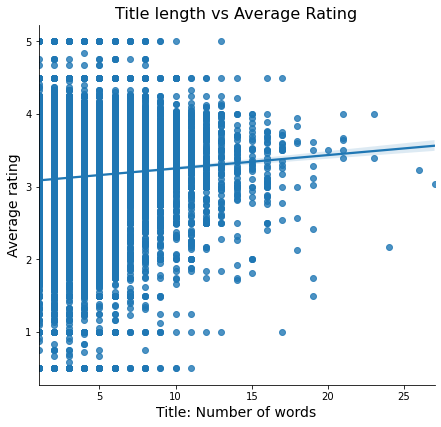

In [24]:
# get a dictionary for movie id and average rating
d={'rating':'avg_rating'}
dfr1 = df_ratings.groupby('movieId').agg({'rating':'mean'}).rename(columns=d).reset_index()
ratings_dict = dict(zip(dfr1.movieId, dfr1.avg_rating))

# new column with the length of the title
df_movies['len_title'] = [len(df_movies.title2[i].split()) for i in range(len(df_movies))]
# add average ratings
df_movies['avg_rating'] = df_movies['movieId'].map(ratings_dict)

# plot
sns.lmplot('len_title', 'avg_rating', data=df_movies)

plt.title("Title length vs Average Rating", fontsize=16)
plt.xlabel("Title: Number of words", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [25]:
from scipy.stats import pearsonr
dff=df_movies.dropna()
corr_coeff = np.corrcoef(dff['len_title'], dff['avg_rating'])[0, 1]
corr_coeff

0.0694303172129126

In [26]:
pearsonr(dff['len_title'], dff['avg_rating'])[0]

0.06943031721291258

We got a very small positive correlation coefficient which means **as the number of words in the title increases, so does the average rating.**

### Plot user rating counts trending

In [27]:
d={'userId':'rating_cnt'}
dfr1 = df_ratings.groupby('rating_year').agg({'userId':'size'}).rename(columns=d).reset_index()
# fig = px.line(dfr1, x="year", y="rating_cnt", title='Total rating counts per year')
# fig.show()

In [28]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="Total rating counts per year", y_axis_type="linear", plot_height = 400,
           tools = TOOLS, plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Total rating counts per year'
# p.circle(2000, dfm1.movie_cnt.mean(), size = 10, color = 'red')

p.line(dfr1.rating_year, dfr1.rating_cnt,line_color="purple", line_width = 3)
p.select_one(HoverTool).tooltips = [
    ('year', '@x'),
    ('Total rating counts', '@y'),
]

output_file("line_chart.html", title="Line Chart")
show(p)

### Bin ratings

In [29]:
bins=[0, 1, 2,3,4,5]
pd.cut(df_ratings['rating'], bins).value_counts()

(3, 4]    7762082
(2, 3]    5174591
(4, 5]    4433484
(1, 2]    1710249
(0, 1]     919857
Name: rating, dtype: int64

In [30]:
df_ratings['rating_bins']=pd.cut(df_ratings['rating'], bins)
df_ratings['rating_bins'].value_counts().sort_index(ascending=False)

(4, 5]    4433484
(3, 4]    7762082
(2, 3]    5174591
(1, 2]    1710249
(0, 1]     919857
Name: rating_bins, dtype: int64

In [31]:
# pecentage
df_ratings['rating_bins'].value_counts().sort_index(ascending=False)/len(df_ratings)

(4, 5]    0.221671
(3, 4]    0.388099
(2, 3]    0.258726
(1, 2]    0.085511
(0, 1]    0.045992
Name: rating_bins, dtype: float64

Text(0, 0.5, '')

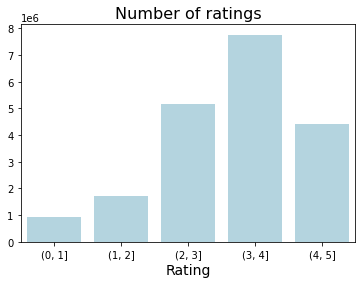

In [32]:
sns.countplot(x='rating_bins', data=df_ratings, color='lightblue')
plt.title("Number of ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("", fontsize=14)

### What are the most popular top 10 movies with highest mean ratings?

In [33]:
d={'userId':'total_cnt'}
rating_cnt = df_ratings.groupby('title').agg({'userId':'size'}).rename(columns=d).reset_index()
rating_cnt.sort_values(by=['total_cnt'],ascending=False).head(10)

,title,total_cnt
18825,Pulp Fiction (1994),67310
8717,Forrest Gump (1994),66172
20780,"Shawshank Redemption, The (1994)",63366
20995,"Silence of the Lambs, The (1991)",63299
12646,Jurassic Park (1993),59715
21872,Star Wars: Episode IV - A New Hope (1977),54502
3507,Braveheart (1995),53769
22984,Terminator 2: Judgment Day (1991),52244
15187,"Matrix, The (1999)",51334
20318,Schindler's List (1993),50054


### How does the average rating of a movie relate to the number of ratings it has received?

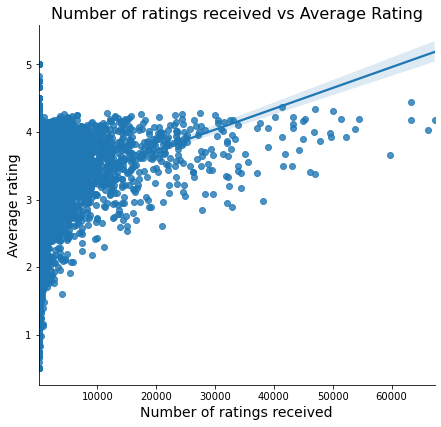

In [34]:
# get a dictionary with movies and total counts
d={'userId':'total_cnt'}
rating_cnt = df_ratings.groupby('movieId').agg({'userId':'size'}).rename(columns=d).reset_index()
r_dict = dict(zip(rating_cnt.movieId, rating_cnt.total_cnt))

# add total counts
df_movies['total_rating_cnt'] = df_movies['movieId'].map(r_dict)

# lmplot
sns.lmplot('total_rating_cnt', 'avg_rating', data = df_movies)
plt.title("Number of ratings received vs Average Rating", fontsize=16)
plt.xlabel("Number of ratings received", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [35]:
from scipy.stats import pearsonr
dff=df_movies.dropna()
corr_coeff = np.corrcoef(dff.total_rating_cnt, dff.avg_rating)[0,1]
corr_coeff

0.14343953248774977

In [36]:
pearsonr(dff.total_rating_cnt, dff.avg_rating)[0]

0.14343953248774977

### plot genre

In [37]:
import pandas as pd 
import pandas_explode 
pandas_explode.patch() # adds a `df.explode` method to all DataFrames 
df_movies2= pd.read_csv(os.path.join(data_path, movies_filename),usecols=['movieId', 'title','genres'], dtype={'movieId': 'int32', 'title': 'str'})

# df_movies2.genres = df_movies2.genres.str.split('|')
df_movies2 = df_movies2.explode('genres')
df_movies2.head()

,movieId,title,genres
0,1,Toy Story (1995),A
0,1,Toy Story (1995),d
0,1,Toy Story (1995),v
0,1,Toy Story (1995),e
0,1,Toy Story (1995),n


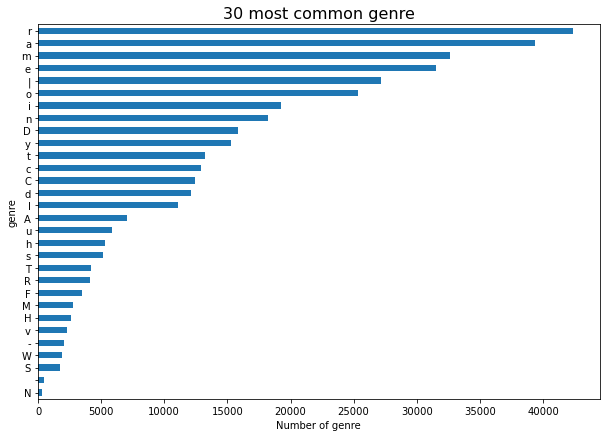

In [38]:
n=30
# most tagged names
df_movies2['genres'].value_counts(ascending=True)[-n:].plot(kind='barh')

plt.title("{} most common genre".format(n), fontsize=16)
plt.xlabel("Number of genre")
plt.ylabel("genre")

plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()


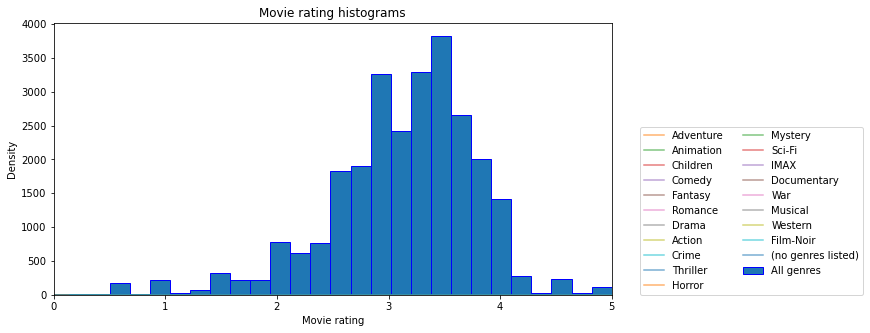

In [39]:
# plot yearly trending per genre
dftmp = df_ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = df_movies[df_movies[genre]==True]
    dftmp = df_ratings[df_ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

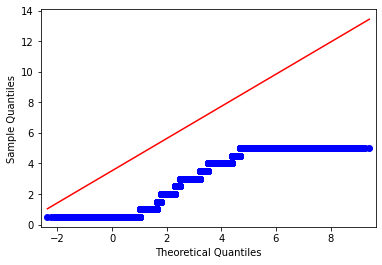

In [40]:
import pylab
import statsmodels.api as sm
mu=np.mean(df_ratings['rating'].dropna())
sigma=np.var(df_ratings['rating'].dropna())
sm.qqplot(df_ratings['rating'], loc = mu, scale = sigma, line='s')
pylab.show()

In [41]:
from scipy.stats import kurtosis
from scipy.stats import skew
print("mean : ", np.mean(df_ratings['rating'].dropna()))
print("var  : ", np.var(df_ratings['rating'].dropna()))
print("skew : ",skew(df_ratings['rating'].dropna()))
print("excess kurtosis : ",kurtosis(df_ratings['rating'].dropna()))

mean :  3.5255287
var  :  1.1066805
skew :  -0.6553115248680115
excess kurtosis :  0.13746752211657665


1. we got negative skewness which means the mass of th distribution is concentrated on the right which fits the plog above
2. Kurtosis is a measure of the thickness of the tails of a distribution. Excess kurtosis = kurtosis - 3. Excess kurtosis is not ZERO telling us that the data is not normal distrubuted. 

We are able to tell that the data is not normal by plot QQ plot and calcuate skewness and excess kurtosis. However, let's still run normality test to double check our conclusion. 

### Perform a statistical test for normalit


### Kolmogorov-Smirnov
The Kolmogorov–Smirnov tests if a sample distribution fits a cumulative distribution function (CDF) of are referenced distribution. Or, if the CDF between of two different samples fit each other. These are not necessarily just for normal distributions, but we’ll use it in our example. Essentially, we are testing the sample data against another sample, to compare their distributions for similarities.
Similar to Shapiro-Wilk, our null hypothesis for our sample is the distribution is identical to the other distribution we’re testing it against. If p < .05 we can reject the null, and conclude our sample distribution is not identical to a normal distribution.

In [43]:
stats.kstest(df_ratings['rating'].dropna(),'norm', args=(mu, sigma))

KstestResult(statistic=0.16570544657699904, pvalue=0.0)

In [44]:
p_value = stats.kstest(df_ratings['rating'].dropna(),'norm', args=(mu, sigma))[1]
print('p_value', p_value)
if p_value <= 0.05:
    print('Null hypothesis of normality is rejected')
else:
    print('Null hypothesis can not be rejected')

p_value 0.0
Null hypothesis of normality is rejected


### tags


In [45]:
df_tags.tag.nunique()

38643

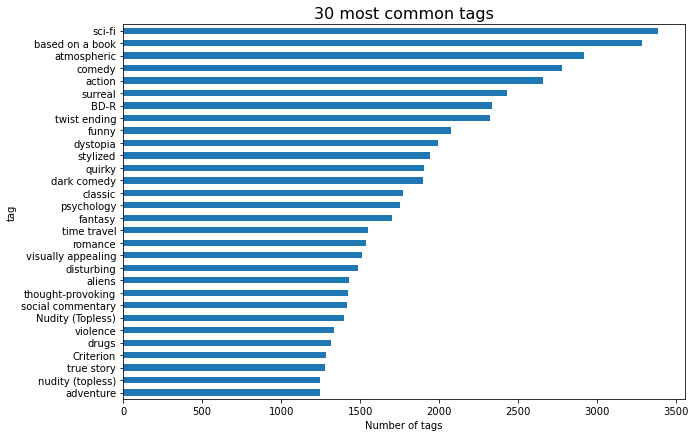

In [46]:
n=30
# most tagged names
df_tags['tag'].value_counts(ascending=True)[-n:].plot(kind='barh')

plt.title("{} most common tags".format(n), fontsize=16)
plt.xlabel("Number of tags")
plt.ylabel("tag")

plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()


### Is having more tags better?

In [47]:
df_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


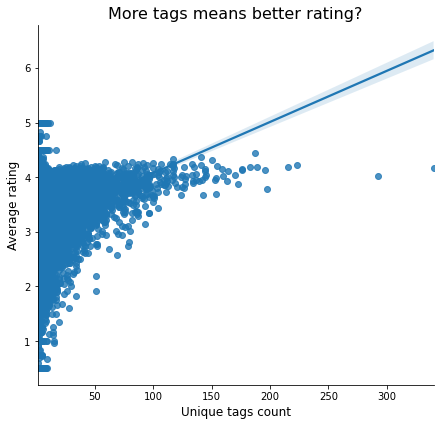

In [49]:
# built a movie id and tag dictionary 
df=df_tags.groupby('movieId')['tag'].nunique().reset_index().rename(columns={"tag":"unique_tag_cnt"})
tags=dict(zip(df.movieId, df.unique_tag_cnt))

# add tags
df_movies['unique_tag_cnt']=df_movies['movieId'].map(tags)

#plot
sns.lmplot('unique_tag_cnt', 'avg_rating',data=df_movies)
plt.title("More tags means better rating?", fontsize =16)
plt.xlabel("Unique tags count", fontsize=12)
plt.ylabel("Average rating", fontsize = 12)
plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()


In [50]:
# Correlation coefficient
dff=df_movies.dropna()
corr_coeff = np.corrcoef(dff['unique_tag_cnt'], dff['avg_rating'])[0, 1]
corr_coeff

0.26637361301113666

We got a small positive correlation coefficent which means **as the number of unique tags increases, so does the average rating.**